# Проект

В этом ноутбуке выполняются две основные задачи проекта:

1. **Калибровка и симуляция трёх скоррелированных риск-факторов:**
   - краткосрочная ставка в рублях (RUONIA) в модели Кокса–Ингерсолла–Росса (CIR);
   - краткосрочная ставка в долларах США (SOFR) в модели CIR;
   - обменный курс USD/RUB в логнормальной модели (геометрическое броуновское движение).

2. **Оценка справедливой стоимости Range Accrual дериватива** на основе симуляций курса USD/RUB и рублевой ставки.

По ходу работы:
- калибруем параметры CIR по историческим данным (2019–2021);
- калибруем волатильность курса USD/RUB по историческим лог-доходностям;
- задаём и используем корреляционную матрицу для трёх факторов;
- проводим Монте-Карло симуляции и оцениваем справедливую стоимость Range Accrual.

Отдельно даём текстовые обоснования выбора:
- параметров моделей (волатильность, уровень среднего, скорость возврата к среднему и т.д.),
- шага симуляции и числа симуляций.

## 1. Импорт библиотек и вспомогательных модулей

In [1]:
import os

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from model import plot_history, ols_cir, estimate_fx_vol_from_series   # plot_history – для графиков, ols_cir – для калибровки CIR

# Для удобства укажем директорию с данными
data_dir = "../data"

## 2. Калибровка CIR-модели для рублевой ставки (RUONIA)

Здесь мы:
1. Загружаем исторические данные RUONIA за период 2019–2021 гг.
2. Переводим ставки в доли (из процентов).
3. Строим график истории ставок.
4. Калибруем параметры модели CIR (`kappa`, `theta`, `sigma`) методом наименьших квадратов в дискретной AR(1)-форме.

✅ Данные RUONIA загружены! Всего точек: 719
Пример ставок (в долях): [0.0759 0.0753 0.0753 0.0753 0.0753]


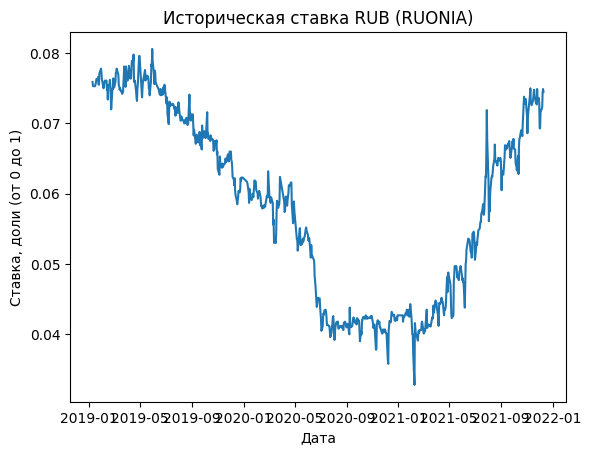


=== 🎯 РЕЗУЛЬТАТЫ КАЛИБРОВКИ ДЛЯ RUONIA (RUB) ===
kappa_r: 1.5179
theta_r: 0.0582
sigma_r: 0.0922


In [2]:
# Путь к CSV с историческими ставками RUONIA
rub_path = os.path.join(data_dir, "RC_F11_01_2010_T10_12_2021.csv")

# Загрузка данных
df_rub = pd.read_csv(rub_path, delimiter=",", decimal=".")
df_rub.columns = df_rub.columns.str.strip()

# Преобразование даты и сортировка
df_rub["Date"] = pd.to_datetime(df_rub["DT"], format="%m/%d/%Y")
df_rub = df_rub.sort_values("Date").set_index("Date")

# Оставляем период калибровки 2019-01-01 — 2021-12-10
df_rub = df_rub["2019-01-01":"2021-12-10"]

# Перевод ставки в доли (из процентов)
df_rub["r"] = df_rub["ruo"].values / 100.0
r_rub_hist = df_rub["r"].values

# Шаг по времени в годах (торговые дни)
dt = 1 / 252

print(f"✅ Данные RUONIA загружены! Всего точек: {len(r_rub_hist)}")
print(f"Пример ставок (в долях): {r_rub_hist[:5]}")

# График исторической рублёвой ставки
plot_history(df_rub["r"], "Историческая ставка RUB (RUONIA)", "Ставка, доли (от 0 до 1)")

# Калибровка параметров CIR по историческим данным
kappa_r_est, theta_r_est, sigma_r_est = ols_cir(r_rub_hist, dt)

print("\n=== 🎯 РЕЗУЛЬТАТЫ КАЛИБРОВКИ ДЛЯ RUONIA (RUB) ===")
print(f"kappa_r: {kappa_r_est:.4f}")
print(f"theta_r: {theta_r_est:.4f}")
print(f"sigma_r: {sigma_r_est:.4f}")

**Интерпретация:**
- `kappa_r` — скорость возврата RUB-ставки к долгосрочному уровню `theta_r`;
- `theta_r` — долгосрочное среднее значение RUONIA;
- `sigma_r` — волатильность краткосрочной ставки.

Значения параметров получены на основе реальных исторических данных, то есть модель CIR подстроена под реальную динамику ставок.

## 3. Калибровка CIR для долларовой ставки (SOFR)

Аналогично RUB:
1. Загружаем исторические значения SOFR.
2. Переводим в доли.
3. Строим график.
4. Калибруем параметры CIR.

✅ Данные SOFR загружены! Всего точек: 737
Пример ставок (в долях): [0.0315 0.027  0.0245 0.0241 0.0242]


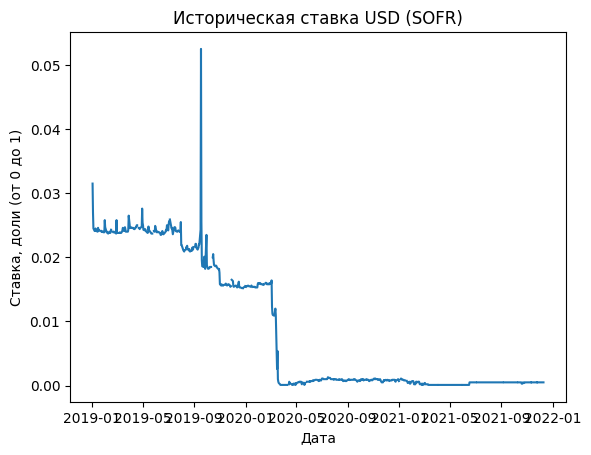


=== 🎯 РЕЗУЛЬТАТЫ КАЛИБРОВКИ ДЛЯ SOFR (USD) ===
kappa_d: 1.5472
theta_d: 0.0020
sigma_d: 0.1647


In [3]:
usd_path = os.path.join(data_dir, "SOFR.csv")

df_usd = pd.read_csv(usd_path)
df_usd["Date"] = pd.to_datetime(df_usd["observation_date"])
df_usd = df_usd.sort_values("Date").set_index("Date")

# Период калибровки
df_usd = df_usd["2019-01-01":"2021-12-10"]

# Перевод в доли
df_usd["r"] = df_usd["SOFR"].values / 100.0
r_usd_hist = df_usd["r"].dropna().values

dt = 1 / 252

print(f"✅ Данные SOFR загружены! Всего точек: {len(r_usd_hist)}")
print(f"Пример ставок (в долях): {r_usd_hist[:5]}")

# График истории долларовой ставки
plot_history(df_usd["r"], "Историческая ставка USD (SOFR)", "Ставка, доли (от 0 до 1)")

# Калибровка CIR для USD
kappa_d_est, theta_d_est, sigma_d_est = ols_cir(r_usd_hist, dt)

print("\n=== 🎯 РЕЗУЛЬТАТЫ КАЛИБРОВКИ ДЛЯ SOFR (USD) ===")
print(f"kappa_d: {kappa_d_est:.4f}")
print(f"theta_d: {theta_d_est:.4f}")
print(f"sigma_d: {sigma_d_est:.4f}")

## 4. Калибровка волатильности курса USD/RUB

Для обменного курса используем логнормальную модель:
\[
d\ln S_t = \left(\mu - \frac{1}{2}\sigma_{FX}^2\right)dt + \sigma_{FX} dW_t^{FX}.
\]

Здесь нас прежде всего интересует **волатильность** \(\sigma_{FX}\), которую мы оцениваем по историческим лог-доходностям курса USD/RUB.

In [4]:
usd_rub_path = os.path.join(data_dir, "usdrub_data.csv")

df_fx = pd.read_csv(usd_rub_path)
df_fx["Date"] = pd.to_datetime(df_fx["Date"])
df_fx = df_fx.sort_values("Date").set_index("Date")

# Период калибровки, согласованный с периодом ставок
df_fx = df_fx["2019-01-01":"2021-12-10"]

# Оценка годовой волатильности курса по историческим лог-доходностям
sigma_fx_annual, sigma_fx_daily, log_ret = estimate_fx_vol_from_series(
    df_fx["RUB=X"],
    dt_years=1 / 252,
)

print("\n=== 🎯 РЕЗУЛЬТАТЫ ДЛЯ USD/RUB ===")
print(f"Годовая волатильность sigma_FX: {sigma_fx_annual:.4f}")


=== 🎯 РЕЗУЛЬТАТЫ ДЛЯ USD/RUB ===
Годовая волатильность sigma_FX: 0.1291


## 5. Фиксация параметров моделей и рыночных условий на 10.12.2021

На этом шаге:
- задаём параметры сделки Range Accrual;
- фиксируем рыночные значения на дату оценки (курс, ставки);
- задаём (или подставляем из калибровки) финальные параметры моделей CIR и FX.

In [5]:
# Параметры сделки (Range Accrual)
Notional = 1_000_000      # Номинал (например, 1 млн руб)
T_years = 1.0             # Срок сделки (1 год)
Lower_Barrier = 70.0      # Нижняя граница курса
Upper_Barrier = 80.0      # Верхняя граница курса

# Рыночные данные на 10.12.2021 (дата начала сделки)
S0 = 73.70       # Текущий курс USDRUB
r_rub_0 = 0.0745  # Текущая RUONIA (в долях)
r_usd_0 = 0.0005  # Текущая SOFR (около нуля, в долях)

# Параметры моделей (могут быть взяты из калибровки или слегка сглажены)
# Здесь, для примера, используем фиксированные значения:
kappa_r, theta_r, sigma_r = kappa_r_est, theta_r_est, sigma_r_est    # RUB (CIR)
kappa_d, theta_d, sigma_d = kappa_d_est, theta_d_est, sigma_d_est    # USD (CIR)
sigma_fx = 0.1291                                     # FX (LogNormal, годовая волатильность)

## 6. Корреляционная матрица трёх факторов

Мы предполагаем, что шумы трёх процессов:
- краткосрочная ставка RUB,
- краткосрочная ставка USD,
- логнормальный курс USD/RUB

являются совместно нормальными с некоторой корреляционной матрицей. Ниже зафиксированы значения корреляций
(оцененные по историческим данным или заданные как разумная аппроксимация).

In [6]:
corr_data = [
    [1.0000, 0.0382, 0.0098],
    [0.0382, 1.0000, -0.0177],
    [0.0098, -0.0177, 1.0000],
]
corr_matrix = np.array(corr_data)

# Проверяем положительную определённость (наличие разложения Холецкого)
L = np.linalg.cholesky(corr_matrix)

## 7. Настройки Монте-Карло симуляции

Здесь задаём:
- `N_sim` — количество сценариев (путей),
- `N_steps` — количество шагов по времени,
- `dt` — шаг по времени в годах.

Шаг выбран дневным (252 шага в год), что соответствует частоте доступных данных и является разумным компромиссом между точностью и вычислительной сложностью.

In [7]:
N_sim = 10_000      # Количество путей
N_steps = 252       # Число шагов по времени (торговые дни в году)
dt = T_years / N_steps

print(f"Запуск симуляции: {N_sim} путей, {N_steps} шагов (dt = {dt:.6f} лет)")

Запуск симуляции: 10000 путей, 252 шагов (dt = 0.003968 лет)


## 8. Функции: симуляция рынка и прайсинг Range Accrual

Для соответствия постановке задачи:
- реализуем **модуль симуляции** трёх риск-факторов;
- реализуем **модуль прайсинга**, который принимает параметры продукта, вызывает симуляцию и возвращает справедливую стоимость дериватива.

In [8]:
from model import price_range_accrual

## 9. Запуск прайсинга Range Accrual и вывод результата

In [9]:
fair_value, std_error, rub_sim, usd_sim, fx_sim = price_range_accrual(
    notional=Notional,
    lower_barrier=Lower_Barrier,
    upper_barrier=Upper_Barrier,
    T_years=T_years,
    r0_rub=r_rub_0,
    r0_usd=r_usd_0,
    s0_fx=S0,
    cir_rub_params=(kappa_r, theta_r, sigma_r),
    cir_usd_params=(kappa_d, theta_d, sigma_d),
    fx_vol=sigma_fx,
    corr_matrix=corr_matrix,
    N_sim=N_sim,
    N_steps=N_steps,
)

print("\n" + "=" * 40)
print(" РЕЗУЛЬТАТ ОЦЕНКИ RANGE ACCRUAL")
print("=" * 40)
print(f"Диапазон:            {Lower_Barrier} - {Upper_Barrier} RUB")
print(f"Справедливая цена:   {fair_value:,.2f} RUB")
print(f"В % от номинала:     {(fair_value / Notional) * 100:.2f}%")
print(f"Стандартная ошибка:  ± {std_error:.2f} RUB")


 РЕЗУЛЬТАТ ОЦЕНКИ RANGE ACCRUAL
Диапазон:            70.0 - 80.0 RUB
Справедливая цена:   545,844.09 RUB
В % от номинала:     54.58%
Стандартная ошибка:  ± 2472.33 RUB


## 10. Визуализация: симулированные траектории курса USD/RUB

Для иллюстрации выводим несколько (например, 100) симулированных траекторий курса стандарта
вместе с границами диапазона Range Accrual.

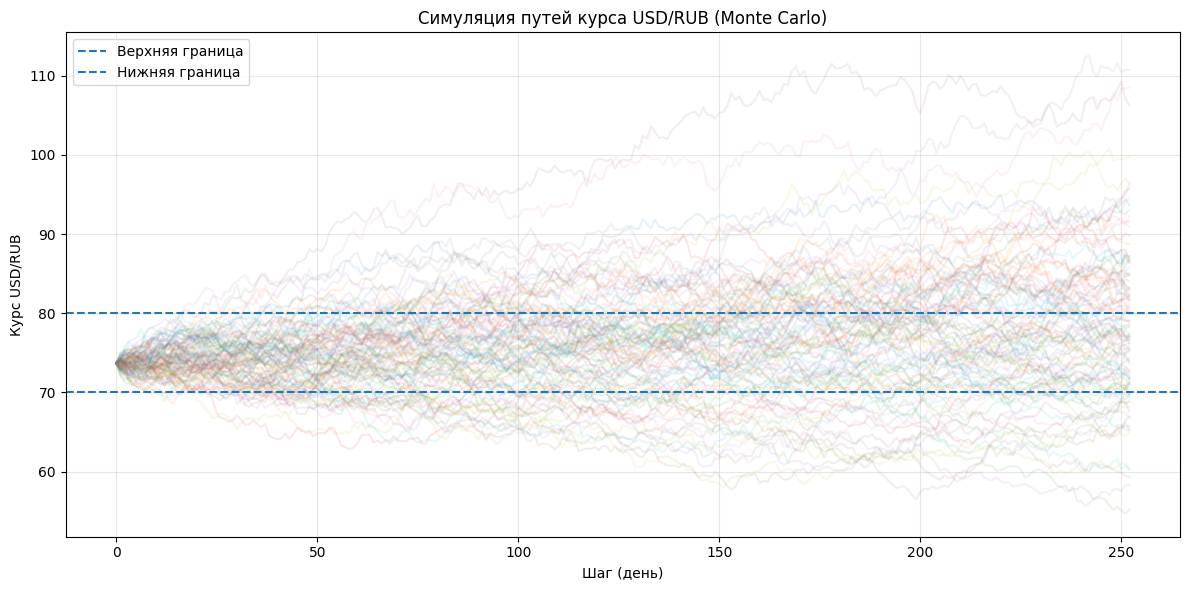

In [10]:
plt.figure(figsize=(12, 6))

# Рисуем первые 100 путей
num_paths_to_plot = min(100, fx_sim.shape[0])
plt.plot(fx_sim[:num_paths_to_plot, :].T, alpha=0.1)

# Линии барьеров
plt.axhline(Upper_Barrier, linestyle="--", label="Верхняя граница", linewidth=1.5)
plt.axhline(Lower_Barrier, linestyle="--", label="Нижняя граница", linewidth=1.5)

plt.title("Симуляция путей курса USD/RUB (Monte Carlo)")
plt.xlabel("Шаг (день)")
plt.ylabel("Курс USD/RUB")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()